In [1]:
# Copyright (c) Microsoft Corporation. All rights reserved
# Licensed under the MIT License.
%matplotlib inline
%load_ext autoreload
%autoreload 2
import sys
sys.path.append("..")
import os
import time
import itertools

import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import scipy.optimize

import shapely.geometry
import fiona.transform

from sklearn.metrics import accuracy_score, mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

from temporal_cluster_matching import utils, DataInterface, algorithms

In [2]:
def show_two_results(hist1, hist2, bins, label1, label2, title, color1="#1f77b4", xlabel="KL divergence"):
    
    bin_width = bins[1] - bins[0]
    
    
    plt.figure()
    plt.bar(bins[:-1], hist1, width=bin_width, alpha=0.5, label=label1, color=color1)
    plt.bar(bins[:-1], hist2, width=bin_width, alpha=0.5, label=label2, color="#ff7f0e")
    plt.legend(loc="upper right", fontsize=15)
    plt.xlabel(xlabel, fontsize=15)
    plt.ylabel("Relative frequency", fontsize=15)
    plt.title(title, fontsize=15)
    plt.xticks(fontsize=13)
    plt.yticks(fontsize=13)
    plt.ylim([0,0.084])
    plt.show()
    plt.close()

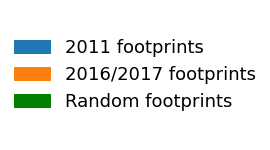

In [3]:
labels = ['2011 footprints', '2016/2017 footprints', 'Random footprints']
colors = ['#1f77b4', '#ff7f0e', 'green']
plt.figure(figsize=(4, 2.5))
patches = [
    mpl.patches.Patch(color=color, label=label)
    for label, color in zip(labels, colors)
]
plt.axis("off")
plt.legend(patches, labels, loc='center', frameon=False, fontsize=18)
plt.show()
plt.close()

## NAIP / Poultry barns

In [4]:
directories = [
    fn
    for fn in os.listdir("../results/kl/")
    if fn.startswith("poultry_barns_random") and not os.path.isfile(os.path.join("../results/", fn))
]

In [5]:
labeled_idxs, labeled_years = utils.get_poultry_barn_labels("../data/")

In [8]:
results = {
    "method": [],
    "dataset": [],
    "num_clusters": [],
    "buffer": [],
    "mae": [],
    "acc": [],
    "bc_coefficient": [],
    "theta": []
}

### Figures that show distributions of KL divergences

In [9]:
bins = np.linspace(0,10,num=100)
for directory in directories:
    
    random_dataset, num_clusters, buffer = directory.split("-")
    num_clusters = int(num_clusters)
    buffer = int(buffer)
    
    original_dataset = random_dataset.replace("_random", "")
    
    random_fn = f"../results/kl/{random_dataset}-{num_clusters}-{buffer}/results.csv"
    original_fn = f"../results/kl/{original_dataset}-{num_clusters}-{buffer}/results.csv"
        
    assert os.path.exists(random_fn) and os.path.exists(original_fn)
        
    _, random_all_years, random_all_distances = utils.get_results(random_fn)
    _, original_all_years, original_all_distances = utils.get_results(original_fn)

    distances1 = []
    distances2 = []
    distances3 = []
    for i in range(len(random_all_distances)):
        distances1.extend(random_all_distances[i])
        distances2.append(original_all_distances[i][3])
        distances3.append(original_all_distances[i][0])
        
    distances1 = np.array(distances1)
    distances2 = np.array(distances2)
    distances3 = np.array(distances3)
    distances1 = distances1[~np.isinf(distances1)]
    distances2 = distances2[~np.isinf(distances2)]
    distances3 = distances3[~np.isinf(distances3)]
    
    hist1, _ = np.histogram(distances1, bins=bins)
    hist2, _ = np.histogram(distances2, bins=bins)
    hist3, _ = np.histogram(distances3, bins=bins)
    
    hist1 = hist1 / hist1.sum()
    hist2 = hist2 / hist2.sum()
    hist3 = hist3 / hist3.sum()
    
    bc_coefficient = np.sum(np.sqrt(hist1 * hist2))
    theta_estimate = np.percentile(distances1, 98)
    
    acc, mae = utils.loss_function(labeled_idxs, labeled_years, original_all_distances, original_all_years, theta_estimate, 2018)
    
    results["method"].append("heuristic-theta")
    results["dataset"].append(original_dataset)
    results["num_clusters"].append(num_clusters)
    results["buffer"].append(buffer)
    results["acc"].append(acc)
    results["mae"].append(mae)
    results["bc_coefficient"].append(bc_coefficient)
    results["theta"].append(theta_estimate)

# Sentinel 2 / Solar farms

In [10]:
directories = [
    fn
    for fn in os.listdir("../results/kl/")
    if fn.startswith("solar_farms_reduced_random")
]

### Acc results from learning theta

In [11]:
labeled_idxs, labeled_years = utils.get_solar_farm_labels("../data/")
labeled_idxs = np.array(labeled_idxs)
labeled_years = np.array(labeled_years)
mask = labeled_years != -1
labeled_idxs = labeled_idxs[mask]
labeled_years = labeled_years[mask]
print(labeled_years.shape)

(760,)


### Figures that show distributions of KL divergences

In [12]:
bins = np.linspace(0,10,num=50)
for directory in directories:
    
    random_dataset, num_clusters, buffer = directory.split("-")
    original_dataset = random_dataset.replace("_random", "")
    
    random_fn = f"../results/kl/{random_dataset}-{num_clusters}-{buffer}/results.csv"
    original_fn = f"../results/kl/{original_dataset}-{num_clusters}-{buffer}/results.csv"

    assert os.path.exists(random_fn)
    assert os.path.exists(original_fn), original_fn
        
    _, random_all_years, random_all_distances = utils.get_results(random_fn)
    _, original_all_years, original_all_distances = utils.get_results(original_fn)

    distances1 = []
    distances2 = []
    distances3 = []
    for i in range(len(random_all_distances)):
        distances1.extend(random_all_distances[i])
        distances2.append(original_all_distances[i][3])
        distances3.append(original_all_distances[i][0])
        
    distances1 = np.array(distances1)
    distances2 = np.array(distances2)
    distances3 = np.array(distances3)
    distances1 = distances1[~np.isinf(distances1)]
    distances2 = distances2[~np.isinf(distances2)]
    distances3 = distances3[~np.isinf(distances3)]
    
    hist1, _ = np.histogram(distances1, bins=bins)
    hist2, _ = np.histogram(distances2, bins=bins)
    hist3, _ = np.histogram(distances3, bins=bins)
    
    hist1 = hist1 / hist1.sum()
    hist2 = hist2 / hist2.sum()
    hist3 = hist3 / hist3.sum()
    
    bc_coefficient = np.sum(np.sqrt(hist1 * hist2))
    theta_estimate = np.percentile(distances1, 98)
    
    acc, mae = utils.loss_function(labeled_idxs, labeled_years, original_all_distances, original_all_years, theta_estimate, 2020)
    
    results["method"].append("heuristic-theta")
    results["dataset"].append(original_dataset)
    results["num_clusters"].append(num_clusters)
    results["buffer"].append(buffer)
    results["acc"].append(acc)
    results["mae"].append(mae)
    results["bc_coefficient"].append(bc_coefficient)
    results["theta"].append(theta_estimate)

In [13]:
df = pd.DataFrame.from_dict(results)

In [14]:
df

,method,dataset,num_clusters,buffer,mae,acc,bc_coefficient,theta
0,heuristic-theta,poultry_barns,16,100,0.163000,0.924000,0.084120,1.213688
1,heuristic-theta,poultry_barns,64,200,0.154000,0.936000,0.071000,1.931520
2,heuristic-theta,poultry_barns,32,200,0.170000,0.930000,0.080443,1.756256
3,heuristic-theta,poultry_barns,32,400,0.236000,0.897000,0.093505,2.230692
4,heuristic-theta,poultry_barns,64,400,0.204000,0.922000,0.072066,2.401980
5,heuristic-theta,poultry_barns,64,100,0.172000,0.933000,0.083632,1.513780
6,heuristic-theta,poultry_barns,32,100,0.172000,0.928000,0.079752,1.372300
7,heuristic-theta,poultry_barns,16,200,0.218000,0.903000,0.091819,1.570992
8,heuristic-theta,poultry_barns,16,400,0.385000,0.829000,0.112777,1.953870
9,heuristic-theta,solar_farms_reduced,32,0.016,0.498684,0.689474,0.520333,2.413244


In [15]:
df.to_csv("../results/heuristic-theta_results.csv")

## Rank correlations

In [13]:
from scipy.stats import spearmanr

In [14]:
bc_coefficients, accs = df[df.dataset=="poultry_barns"][["bc_coefficient", "acc"]].values.T
spearmanr(-bc_coefficients, accs)

SpearmanrResult(correlation=0.7666666666666667, pvalue=0.01594401657897401)

In [15]:
bc_coefficients, maes = df[df.dataset=="poultry_barns"][["bc_coefficient", "mae"]].values.T
spearmanr(-bc_coefficients, maes)

SpearmanrResult(correlation=-0.7029350233548073, pvalue=0.03467010659432658)

In [16]:
bc_coefficients, accs = df[df.dataset=="solar_farms_reduced"][["bc_coefficient", "acc"]].values.T
spearmanr(-bc_coefficients, accs)

SpearmanrResult(correlation=0.942857142857143, pvalue=0.004804664723032055)

In [17]:
bc_coefficients, maes = df[df.dataset=="solar_farms_reduced"][["bc_coefficient", "mae"]].values.T
spearmanr(-bc_coefficients, maes)

SpearmanrResult(correlation=-0.942857142857143, pvalue=0.004804664723032055)